# Manual extraction

This just uses the raw data to build communities, seeing with a nearest neighbors algorithm

In [79]:
import pandas as pd

df = pd.read_csv("./vector_field.csv")
df[['final_x', 'final_y']] = df['final_grid'].str.split(',', n=1, expand=True)
df = df.rename({"num_hops":"hops"},axis=1)
# df = df[df['hops'] <= 3]

In [80]:
# keep the original index
df_1 = df[df.hops ==1].reset_index().rename(columns={'index':'original_index'})

In [81]:
from sklearn.neighbors import NearestNeighbors

# Use Python's nearest neighbor implementation to get nearest neighbors
X = df_1[['grid_x','grid_y']].to_numpy()
neigh = NearestNeighbors(n_neighbors=8, radius=1, p=2)
neigh.fit(X)

NearestNeighbors(n_neighbors=8, radius=1)

Create the merge table

In [82]:
import pandas as pd
import numpy as np


neighborhood_info = []
radius=5

for index, row in df_1.iterrows():
    # Use radius_neighbors to find neighbors of the current point within the radius
    distances, indices = neigh.radius_neighbors([[row['grid_x'], row['grid_y']]], radius=radius, return_distance=True)

    # find the point that has distance 0 which is the center of the neighbor
    zero_idx = np.argmin(distances[0])
    center_idx = indices[0][zero_idx]

    for dist, idx in zip(distances[0], indices[0]):
        neighborhood_info.append({'center_index': center_idx, 'neighbor_index': idx, 'distance': dist})
    
Merge_table = pd.DataFrame(neighborhood_info)

# remove center to center distance 
Merge_table = Merge_table[Merge_table['distance'] != 0]

Drop duplicated distances

In [83]:
# Step 1: Create min and max columns for the indices
Merge_table['min_index'] = Merge_table[['center_index', 'neighbor_index']].min(axis=1)
Merge_table['max_index'] = Merge_table[['center_index', 'neighbor_index']].max(axis=1)

# Step 2: Drop duplicates based on the min and max index columns
Merge_table = Merge_table.drop_duplicates(subset=['min_index', 'max_index'])

# Optional: If you don't need the min_index and max_index columns anymore, you can drop them
Merge_table.drop(columns=['min_index', 'max_index'], inplace=True)

Calculate merge probability

The formula for the Gaussian-based probability function with the inclusion of normalization factor is:

$$
\frac{1}{\sqrt{2\pi c^2}} \cdot e^{-\frac{(\text{distance} / \text{radius})^2}{2c^2}}
$$


In [84]:
import math

def normalize_probability(x):
    return 0.2 + 0.6 * x

def merge_probability(distance, radius, error_term):
    probability = max(0, ((radius - distance) / radius) + error_term)
    # probability = normalize_probability(probability)
    return probability

# Gaussian-based probability function
# def gaussian_probability(distance, radius, c):
#     adjusted_distance = distance / radius
#     return 1 / (math.sqrt(2 * math.pi * c**2)) * np.exp(- (adjusted_distance ** 2) / (2 * c ** 2))


error_term = 0
c = 0.4
Merge_table['merge_prob_1'] = Merge_table['distance'].apply(lambda row: merge_probability(row, radius, error_term))
# Merge_table['merge_prob_2'] = Merge_table['distance'].apply(lambda row: gaussian_probability(row, radius, c))

Merge_table

,center_index,neighbor_index,distance,merge_prob_1
2,2,3,3.162278,0.367544
8,5,7,3.162278,0.367544
12,7,9,3.605551,0.278890
16,9,11,3.162278,0.367544
18,10,15,3.605551,0.278890
...,...,...,...,...
3631,292,293,1.000000,0.800000
3632,292,294,2.828427,0.434315
3635,293,295,1.414214,0.717157
3642,293,294,2.236068,0.552786


In [86]:
Merge_table[f'svm_f1_hop_all'] = np.nan

In [87]:
# Disable the warning
pd.options.mode.chained_assignment = None

In [88]:
from sklearn.svm import SVC
from sklearn.metrics import f1_score

df.dropna(subset=['final_x', 'grid_x', 'final_y', 'grid_y'], inplace=True)
df[['final_x', 'grid_x', 'final_y','grid_y']]=df[['final_x', 'grid_x', 'final_y','grid_y']].astype('int')

stable_indices = df_1['original_index'].to_list()

# for hops in range(2, df.hops.max() + 1):
#     print(f"Processing points with hops = {hops}")

for index_a in stable_indices:
    for index_b in stable_indices:
        if index_b <= index_a:  # Avoid duplicate pairs
            continue
        
        converging_to_a = (df['final_x'] == df.at[index_a, 'grid_x']) & (df['final_y'] == df.at[index_a, 'grid_y'])# & (df['hops'] == hops)
        converging_to_b = (df['final_x'] == df.at[index_b, 'grid_x']) & (df['final_y'] == df.at[index_b, 'grid_y'])# & (df['hops'] == hops)

        # Make sure there are points for both attractors in that specific hop
        if converging_to_a.any() and converging_to_b.any():

            converging_points = df[(converging_to_a | converging_to_b)]

            # label the attractors for SVM
            converging_points['label'] = 0 
            converging_points.loc[converging_to_b, 'label'] = 1
            converging_points.loc[converging_to_a, 'label'] = 0
        else:
            continue

        features = converging_points[['grid_x', 'grid_y']]
        labels = converging_points['label'].astype(int)


        svm = SVC(kernel='poly', degree=2, C=0.0001)
        svm.fit(features, labels)

        predictions= svm.predict(features)  
        f1 = f1_score(labels, predictions)

        ##### update 

        # get the indeces for points in the merge table
        merge_index_a = df_1.index[df_1['original_index'] == index_a][0]
        merge_index_b = df_1.index[df_1['original_index'] == index_b][0]


        pair_1 = (Merge_table['center_index'] == merge_index_a) & (Merge_table['neighbor_index'] == merge_index_b)
        pair_2 = (Merge_table['center_index'] == merge_index_b) & (Merge_table['neighbor_index'] == merge_index_a)


        Merge_table.loc[(pair_1 | pair_2, f'svm_f1_hop_all')] = f1

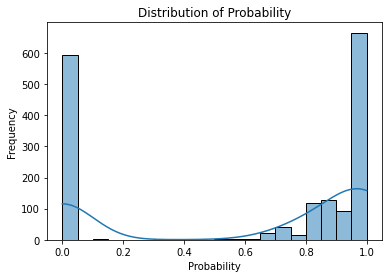

In [89]:
########### C=0.0001, degree=2

import matplotlib.pyplot as plt
import seaborn as sns

# Histogram with a Kernel Density Estimate (KDE) plot using seaborn
sns.histplot(Merge_table['svm_f1_hop_all'], bins=20, kde=True)
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Probability')
plt.show()

In [119]:
# Assuming Merge_table is a pandas DataFrame
Merge_table['svm_merge_prob'] = 1 - Merge_table['svm_f1_hop_all']
Merge_table['final_probability'] = Merge_table[['svm_merge_prob', 'merge_prob_1']].mean(axis=1)


threshold = 0.9
# Filter pairs with merge probability greater than the threshold
high_merge_pairs = Merge_table[Merge_table["final_probability"] > threshold][['center_index', 'neighbor_index', 'final_probability']]

In [120]:
from scipy.sparse.csgraph import connected_components
from scipy.sparse import csr_matrix

# Create a sparse matrix where rows and columns represent points and entries represent whether a pair should be merged
max_point = max(high_merge_pairs["center_index"].max(), high_merge_pairs["neighbor_index"].max())
merge_matrix = csr_matrix((high_merge_pairs["final_probability"].values, 
                           (high_merge_pairs["center_index"].values, high_merge_pairs["neighbor_index"].values)),
                          shape=(max_point + 1, max_point + 1))

# Find connected components, which represent our clusters
n_components, labels = connected_components(csgraph=merge_matrix, directed=False, return_labels=True)

# Create a dataframe to map each point to its cluster
final_clusters = pd.DataFrame({'point': range(len(labels)), 'cluster': labels})

TypeError: 'float' object cannot be interpreted as an integer

In [121]:
# Merge on index to get the grid_id of each cluster label
keep = df_1.merge(final_clusters, left_index=True, right_index=True)[['grid_id','cluster']]

# All the points that end up at stable points are part of the same attractor. Merge them.
final_labels = df.merge(keep, left_on="final_grid", right_on="grid_id", how="left")
final_labels

,grid_x,grid_y,avg_vx,avg_vy,grid_id_x,final_grid,hops,status,result,final_x,final_y,grid_id_y,cluster
0,1,38,3.098754,0.497374,"1,38","39,47",14,Success,"39,47, 14, Success",39,47,"39,47",36.0
1,1,39,2.102776,1.391309,"1,39","39,47",18,Success,"39,47, 18, Success",39,47,"39,47",36.0
2,1,40,4.021628,1.731052,"1,40","39,47",17,Success,"39,47, 17, Success",39,47,"39,47",36.0
3,1,41,2.044954,0.376044,"1,41","39,47",18,Success,"39,47, 18, Success",39,47,"39,47",36.0
4,1,42,0.605981,-0.157267,"1,42","39,47",17,Success,"39,47, 17, Success",39,47,"39,47",36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5285,98,88,-0.065474,0.075242,"98,88","98,88",1,Success,"98,88, 1, Success",98,88,NaN,NaN
5286,98,89,-0.181391,-0.270416,"98,89","98,88",2,Success,"98,88, 2, Success",98,88,NaN,NaN
5287,98,90,-0.292502,-0.446494,"98,90","97,89",2,Success,"97,89, 2, Success",97,89,NaN,NaN
5288,99,88,-0.401486,0.026964,"99,88","98,88",2,Success,"98,88, 2, Success",98,88,NaN,NaN


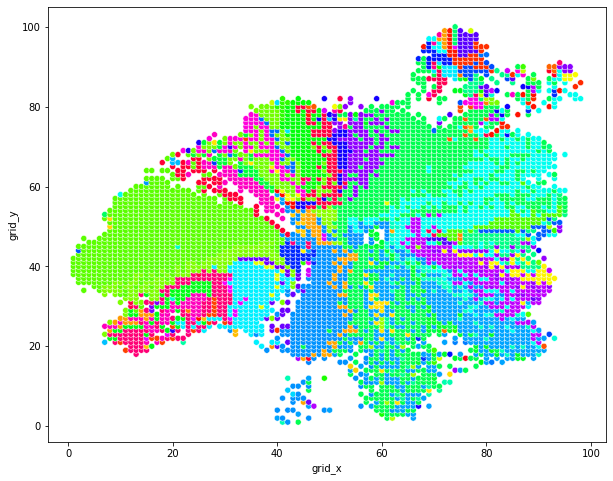

In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def plot_attractors(data,color_key="cluster"):
    # Generating a color palette with as many colors as categories
    palette = sns.color_palette("hsv", len(data[color_key].unique())-1)

    # Randomly shuffle the palette
    random.shuffle(palette)

    # Creating the scatter plot
    plt.figure(figsize=(10, 8))
    scatter_plot = sns.scatterplot(data=data, x='grid_x', y='grid_y',  hue=color_key,palette=palette)
    scatter_plot.legend_.remove()

    plt.show()

plot_attractors(final_labels)

In [33]:
df_1['neighbors'] = df_1.apply(lambda row: neigh.radius_neighbors([[row.grid_x, row.grid_y]], radius=1, return_distance=False), axis=1)

def find_neighborhoods(df):
    cluster_map = {}
    cluster_id = 0

    for nlist in df['neighbors']:
        #unpack
        nlist = nlist[0]
        # Track if we have encountered a cluster in this neighborhood
        encountered_cluster = None

        for item in nlist:
            if item not in cluster_map:
                # If item is not in any cluster, assign it to a new one
                cluster_map[item] = cluster_id
                if encountered_cluster is None:
                    encountered_cluster = cluster_id
                    cluster_id += 1
            else:
                # If item already belongs to a cluster
                if encountered_cluster is not None and encountered_cluster != cluster_map[item]:
                    # Merge this item's cluster with the encountered cluster
                    to_merge_cluster = cluster_map[item]
                    for key, value in cluster_map.items():
                        if value == to_merge_cluster:
                            cluster_map[key] = encountered_cluster
                else:
                    encountered_cluster = cluster_map[item]

    # Invert the cluster_map to get items grouped by their cluster
    neighborhoods = {}
    for item, cluster in cluster_map.items():
        neighborhoods.setdefault(cluster, []).append(item)

    return list(neighborhoods.values())

In [34]:
clusters = find_neighborhoods(df_1)

clust_assn = []
clusters
for idx,c in enumerate(clusters):
    for i in c:
        clust_assn.append([i,idx])

cluster_df = pd.DataFrame(clust_assn,columns=["index","clust_label"])
cluster_df

df_1.reset_index(drop=True, inplace=True)
# Merge on index to get the grid_id of each cluster label
keep = df_1.merge(cluster_df, left_index=True, right_on="index")[['grid_id','clust_label']]

# All the points that end up at stable points are part of the same attractor. Merge them.
final_labels = df.merge(keep, left_on="final_grid", right_on="grid_id", how="left")
final_labels


,grid_x,grid_y,avg_vx,avg_vy,grid_id_x,final_grid,hops,status,result,final_x,final_y,grid_id_y,clust_label
0,2,44,0.034974,-0.104540,"2,44","2,44",1,Success,"2,44, 1, Success",2,44,"2,44",0.0
1,7,21,0.225669,0.191975,"7,21","7,21",1,Success,"7,21, 1, Success",7,21,"7,21",1.0
2,7,53,0.000000,0.000000,"7,53","7,53",1,Success,"7,53, 1, Success",7,53,"7,53",2.0
3,8,50,0.028994,-0.137232,"8,50","8,50",1,Success,"8,50, 1, Success",8,50,"8,50",3.0
4,8,52,-0.010303,-0.979372,"8,52","8,50",2,Success,"8,50, 2, Success",8,50,"8,50",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,98,88,-0.065474,0.075242,"98,88","98,88",1,Success,"98,88, 1, Success",98,88,"98,88",144.0
752,98,89,-0.181391,-0.270416,"98,89","98,88",2,Success,"98,88, 2, Success",98,88,"98,88",144.0
753,98,90,-0.292502,-0.446494,"98,90","97,89",2,Success,"97,89, 2, Success",97,89,"97,89",143.0
754,99,88,-0.401486,0.026964,"99,88","98,88",2,Success,"98,88, 2, Success",98,88,"98,88",144.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

def plot_attractors(data,color_key="clust_label"):
    # Generating a color palette with as many colors as categories
    palette = sns.color_palette("hsv", len(data[color_key].unique())-1)

    # Randomly shuffle the palette
    random.shuffle(palette)

    # Creating the scatter plot
    plt.figure(figsize=(10, 8))
    scatter_plot = sns.scatterplot(data=data, x='grid_x', y='grid_y',  hue=color_key,palette=palette)
    scatter_plot.legend_.remove()

    plt.show()

plot_attractors(final_labels)

# Deeper inspection of data

Just looking at dominant attractors (those that drain large regions).

In [52]:
def flatten_idx(df):
    df.columns = df.columns.map(lambda col: '_'.join(str(s) for s in col if s))
    return df

df_summary = df[["final_grid","hops"]].sort_values("hops",ascending=False).groupby(["final_grid"]).agg({"hops":["max","count"]}).reset_index()
df_summary = flatten_idx(df_summary)
df_summary = df_summary.sort_values("hops_count", ascending=False)
df_summary[df_summary["hops_count"]>50]
df_dom = df[df['final_grid'].isin(df_summary.final_grid)]
plot_attractors(df_dom,"final_grid")


# Attractor Model 

This is the main class for the attractor model.

In [111]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import f1_score
import numpy as np

class AttractorModel:
    def __init__(self, tau=5, chi=.95, poly_degree=3, neighborhood_scale=10):
        """
        Initialize the model with hyperparameters.
        tau: Distance threshold for initial similarity
        chi: Confidence threshold for termination
        poly_degree: Degree of the polynomial kernel for SVM
        """
        self.tau = tau
        self.chi = chi
        self.poly_degree = poly_degree
        self.neighborhood_scale = neighborhood_scale
        self.similarity_matrix = None
        self.attractors = None


    def fit(self, data):
        """
        Fit the model to the data.
        data: Pandas DataFrame with columns grid_x, grid_y, hops, final_x, final_y
        """
        # Initialize the similarity matrix
        self.similarity_matrix = self.initialize_similarity_matrix(data)

        # Refine the similarity matrix iteratively
        self.refine_similarity_matrix(data)

        # Extract attractor assignments from the final similarity matrix
        self.attractors = self.extract_attractors()

    def initialize_similarity_matrix(self, data):
        """
        Initialize the similarity matrix based on adjacency and distance.
        """
        print("Initializing stable points ...")
         # Filter out rows with hops == 1
        stable_points = data[data['hops'] == 1]

         # Create a mapping from stable point indices to original data indices
        index_map = {i: original_index for i, original_index in enumerate(stable_points.index)}

        # Extract coordinates
        coordinates = stable_points[['grid_x', 'grid_y']].values

        # Use NearestNeighbors with Euclidean distance
        nn = NearestNeighbors(radius=self.tau, metric='euclidean')
        nn.fit(coordinates)

        # Find indices and distances of points within radius tau
        distances, indices = nn.radius_neighbors(coordinates, return_distance=True)

        # Initialize the similarity matrix as -1 (fully dissimilar)
        similarity_matrix = -np.ones((len(data), len(data)))

        # Update the similarity matrix based on distances
        for i, (distance_list, neighbor_list) in enumerate(zip(distances, indices)):
            original_i = index_map[i]
            for distance, neighbor in zip(distance_list, neighbor_list):
                original_neighbor = index_map[neighbor]
                if distance == 0:
                    # Adjacent points
                    similarity = 1
                else:
                    # Linear mapping of similarity from 1 to -1 over distance 0 to tau
                    similarity = 1 - 2 * (distance / self.tau)
                similarity_matrix[original_i][original_neighbor] = similarity
                similarity_matrix[original_neighbor][original_i] = similarity  # Symmetric update
        return similarity_matrix


    def refine_similarity_matrix(self, data):
        # Pre-filter stable points
        stable_points = data[data['hops'] == 1]
        stable_indices = stable_points.index.tolist()
        max_hops_in_data = max(data.hops)
        for current_hops in range(2, max_hops_in_data + 1):
            print(f"Processing points with hops = {current_hops}")
            scaling_factor = 1 - current_hops / (max_hops_in_data + 1)

            # Iterate over dyads with low confidence among stable points only
            for idx_a in stable_indices:
                for idx_b in stable_indices:
                    if idx_b <= idx_a:  # Avoid duplicate pairs
                        continue
                    if abs(self.similarity_matrix[idx_a][idx_b]) < self.chi:
                        segregation_f1_score, num_points = self.segregation_analysis(data, idx_a, idx_b, current_hops)
                        self.update_similarity_based_on_segregation(segregation_f1_score, num_points, scaling_factor, idx_a, idx_b)
    
    def segregation_analysis(self, data, index_a, index_b, hops):
        # Use vectorized operations for filtering
        
        converging_to_a = (data['final_x'] == data.at[index_a, 'grid_x']) & (data['final_y'] == data.at[index_a, 'grid_y'])
        converging_to_b = (data['final_x'] == data.at[index_b, 'grid_x']) & (data['final_y'] == data.at[index_b, 'grid_y'])
        converging_points = data[(converging_to_a | converging_to_b) & (data['hops'] == hops)]

        if converging_points.empty:
            return 0, 0  # No points to analyze
            
        
        features = converging_points[['grid_x', 'grid_y']]
        labels = converging_to_a[converging_points.index].astype(int)

        svm = SVC(kernel='poly', degree=self.poly_degree, C=1.0)
        svm.fit(features, labels)

        predictions= svm.predict(features)  
        f1 = f1_score(labels, predictions)
            # Efficiently update the similarity matrix
        for point_index in converging_points.index:
            predicted_label = predictions[converging_points.index.get_loc(point_index)]
            self.similarity_matrix[index_a][point_index] = predicted_label
            self.similarity_matrix[index_b][point_index] = predicted_label
            self.similarity_matrix[point_index][index_a] = predicted_label
            self.similarity_matrix[point_index][index_b] = predicted_label

        return f1, len(converging_points)

    
    def update_similarity_based_on_segregation(self, f1_score, count_points, hop_based_scaling_factor, index_a, index_b):
        # Determine the lower bound for significant segregation (empirical/statistical method)
        # Theoretically, this might be > 0 depending on the algorithm being used.  Empirical studies suggest that SVM span the whole range
        lower_bound_f1 = 0

        # Normalize the f1 score (assuming 0 is the lowest possible score)
        normalized_f1 = (f1_score - lower_bound_f1) / (1 - lower_bound_f1)

        # Invert and map to [-1, 1] if necessary
        delta = 2 * (1 - normalized_f1) - 1 

        # Apply a sigmoid function based on the count of points
        # With neighborhood scale of 10,
        count_multiplier = np.tanh(count_points / self.neighborhood_scale)* hop_based_scaling_factor

        # Update the similarity matrix
        self.similarity_matrix[index_a][index_b] += delta * count_multiplier
        self.similarity_matrix[index_b][index_a] += delta * count_multiplier

    def extract_attractors(self):
        """
        Extract attractor assignments from the final similarity matrix.
        """
        # Implementation goes here
        pass

    def predict(self):
        """
        Return the attractor assignments.
        """
        if self.attractors is None:
            raise Exception("Model not fitted yet.")
        return self.attractors



## Running the model

In [ ]:
# Initialize with default parameters
model = AttractorModel()
model.fit(df)

In [64]:
import pickle
sim_matrix = model.similarity_matrix
with open("sim_matrix.pickle","wb") as f:
    pickle.dump(sim_matrix,f)    

# Utility Code

## Test Data for Attractor model

In [6]:
# Test data

import pandas as pd
import numpy as np

def generate_test_data(num_points=100, grid_size=10, max_hops=5):
    """
    Generate a test dataset for the attractor algorithm.
    
    Parameters:
    num_points (int): Number of points to generate.
    grid_size (int): Size of the grid (grid will be grid_size x grid_size).
    max_hops (int): Maximum number of hops for less stable points.

    Returns:
    pandas.DataFrame: Test dataset with columns grid_x, grid_y, hops, final_x, final_y.
    """
    # Generate grid points
    grid_x = np.random.randint(0, grid_size, num_points)
    grid_y = np.random.randint(0, grid_size, num_points)

    # Generate hops (1 for stable points, up to max_hops for others)
    hops = np.random.randint(1, max_hops+1, num_points)
    # Ensure some points are stable
    hops[:num_points // 4] = 1

    # Generate final positions (for simplicity, can be random within the grid)
    final_x = np.random.randint(0, grid_size, num_points)
    final_y = np.random.randint(0, grid_size, num_points)

    # Create DataFrame
    data = pd.DataFrame({
        'grid_x': grid_x,
        'grid_y': grid_y,
        'hops': hops,
        'final_x': final_x,
        'final_y': final_y
    })

    return data

# Example usage
test_data = generate_test_data()
print(test_data.head())


   grid_x  grid_y  hops  final_x  final_y
0       9       8     1        0        0
1       7       8     1        1        8
2       9       6     1        6        0
3       6       5     1        2        3
4       6       2     1        7        2


## Plotting

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmap(data, grid_size):
    """
    Plot the test data as a heatmap with color corresponding to the number of hops.

    Parameters:
    data (pandas.DataFrame): The test dataset.
    grid_size (int): Size of the grid.
    """
    # Create a grid initialized with zeros
    heatmap_grid = np.zeros((grid_size, grid_size))

    # Populate the grid with the number of hops
    for _, row in data.iterrows():
        heatmap_grid[row['grid_y'], row['grid_x']] = row['hops']

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(heatmap_grid, annot=True, cmap='viridis', square=True, cbar_kws={'label': 'Number of Hops'})
    plt.title("Heatmap of Grid Points by Number of Hops")
    plt.xlabel("Grid X")
    plt.ylabel("Grid Y")
    plt.show()

def plot_similarity(sim_matrix):
    """
    Plot the test data as a heatmap with color corresponding to the number of hops.

    Parameters:
    data (pandas.DataFrame): The test dataset.
    grid_size (int): Size of the grid.
    """
    
    # Create the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(sim_matrix, annot=False, cmap='viridis', square=True, cbar_kws={'label': 'Similarity'})
    plt.title("Heatmap of Similarity Matrix")
    plt.xlabel("Points")
    plt.ylabel("Points")

# Example usage
#plot_heatmap(test_data, grid_size=10)




We should expect to see the number of stable points here...

In [19]:
test = test_data[test_data['hops'] == 1]
test.shape

(47, 5)

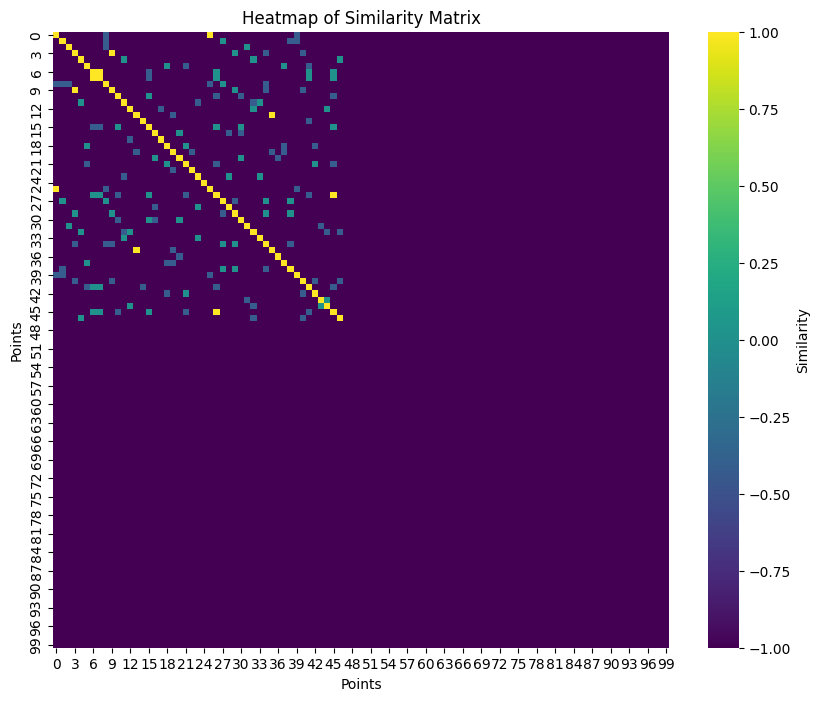

In [18]:
# Example usage
model = AttractorModel(tau=2, chi=0.7, poly_degree=3)
model.fit(test_data)
plot_similarity(model.similarity_matrix)

In [23]:
from sklearn.metrics import f1_score

true_labels = [1] * 50 + [0] * 50  # True labels (50 points each for Class 0 and Class 1)
predicted_labels = [0] * 10 + [1] * 40 + [0] * 45 + [1] * 5  # Predicted labels as per the scenario


f1 = f1_score(true_labels, predicted_labels)
f1


0.8421052631578948

## Empirical examination of SVM

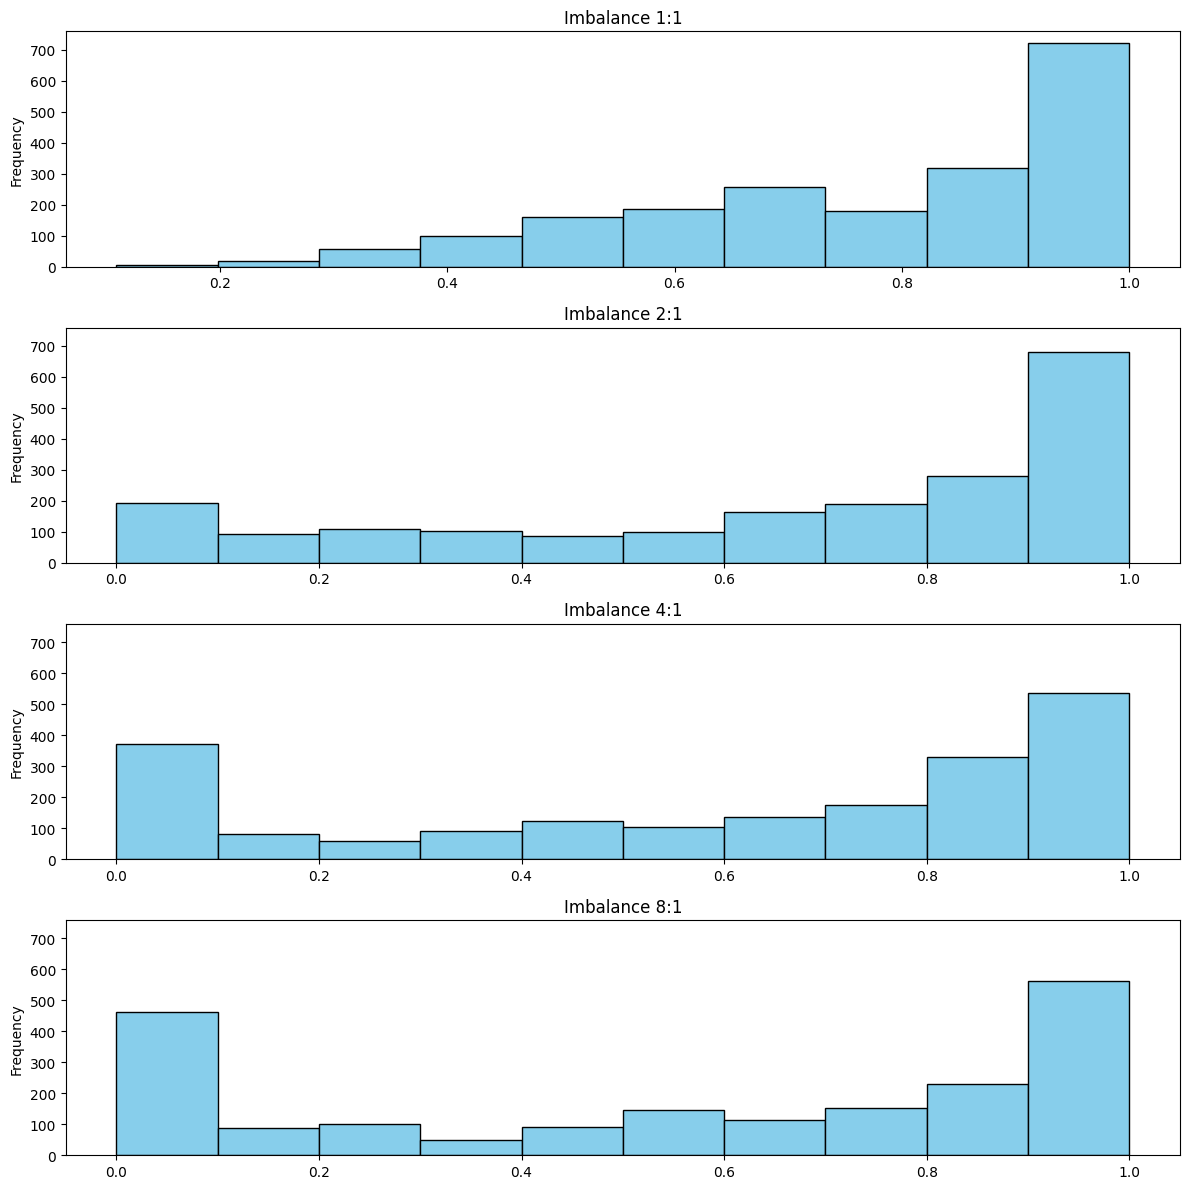

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import f1_score

f1_zero_data = []

# Function to generate synthetic data with a specified level of class imbalance and mixing
def generate_data(n, imbalance_ratio, mixing_factor):
    # Total number of points for each class
    n_class0 = int(n * imbalance_ratio / (1 + imbalance_ratio))
    n_class1 = n - n_class0

    # Generate class 0 data
    class0_data = np.random.randn(n_class0, 2)

    # Generate class 1 data with a specified mixing factor
    class1_data = np.random.randn(n_class1, 2) + mixing_factor

    # Combine and label the data
    X = np.vstack((class0_data, class1_data))
    y = np.array([0] * n_class0 + [1] * n_class1)

    return X, y

# Function to calculate F1 score for different levels of mixing
def calculate_f1_scores(n, imbalance_ratios, mixing_factors, n_iterations=100):
    f1_scores = {imbalance: [] for imbalance in imbalance_ratios}

    for imbalance_ratio in imbalance_ratios:
        temp_scores = []
        for mixing_factor in mixing_factors:
            
            for _ in range(n_iterations):
                # Generate data
                X, y = generate_data(n, imbalance_ratio, mixing_factor)

                # Train SVM
                clf = SVC(kernel='poly',degree=3)
                clf.fit(X, y)

                # Predict and calculate F1 score
                predictions = clf.predict(X)
                score = f1_score(y, predictions)
                temp_scores.append(score)
                if score > .5 and score < .6:
                    f1_zero_data.append((X,y,clf))
            
            # Average F1 score for each mixing factor
            
        f1_scores[imbalance_ratio]=temp_scores

    return f1_scores

# Parameters
n = 100  # Number of points
imbalance_ratios = [1, 2, 4, 8]  # Different levels of class imbalance
mixing_factors = np.linspace(0, 3, 20)  # Levels of mixing across the decision boundary

# Calculate F1 scores
f1_score_results = calculate_f1_scores(n, imbalance_ratios, mixing_factors)
n_rows = len(imbalance_ratios)
# Plotting the F1 scores
fig, axes = plt.subplots(n_rows, 1, figsize=(12, n_rows * 3), sharey=True)


for i, imbalance in enumerate(imbalance_ratios):
    scores = f1_score_results[imbalance]
    ax = axes[i]
    ax.hist(scores, bins=10, color='skyblue', edgecolor='black')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Imbalance {imbalance}:1')
    

plt.tight_layout()
plt.show()

In [70]:
len(f1_zero_data)

445

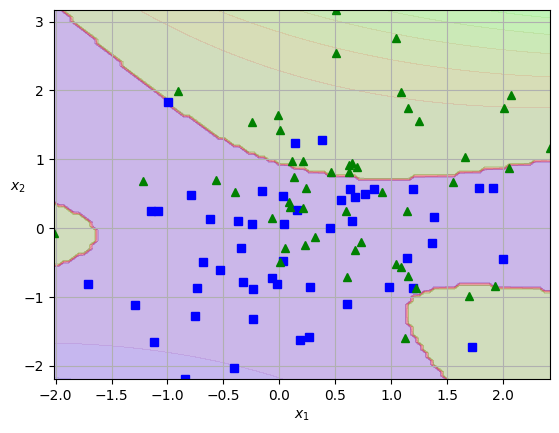

In [73]:

def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$", rotation=0)

X,y,clf = f1_zero_data[100]
extents = [min(X[:,0]),max(X[:,0]),min(X[:,1]),max(X[:,1])]

plot_predictions(clf, extents)
plot_dataset(X, y, extents)

## Inspecting scaling 

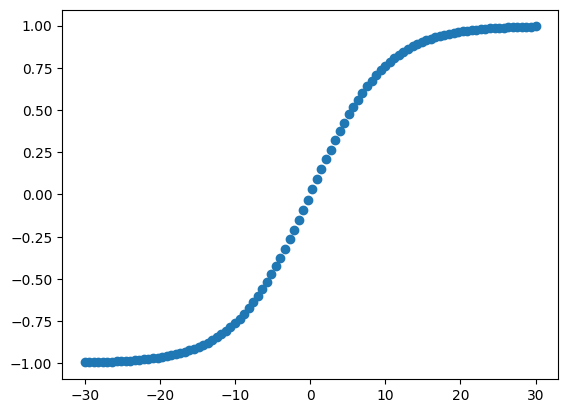

In [11]:
import numpy as np 
import matplotlib.pyplot as plt
x = np.linspace(-30,30,100)
y = np.tanh(x/10)

plt.scatter(x,y)